In [1]:
from pathlib import Path
from dataclasses import dataclass

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
import cmocean

from shapely.affinity import translate
from shapely.geometry import Point

In [2]:
@dataclass
class Extent:
    lats: tuple[float, float]
    lons: tuple[float, float]

    def __post_init__(self):
        if self.lats[0] > self.lats[1]:
            self.up_lat, self.down_lat = self.lats
        else:
            self.down_lat, self.up_lat = self.lats

        if self.lons[0] < self.lons[1]:
            self.left_lon, self.right_lon = self.lons
        else:
            self.right_lon, self.left_lon = self.lons

    def as_xr_slice(self):
        if self.left_lon < 0:
            pos_left_lon = 360 + self.left_lon

        if self.right_lon < 0:
            pos_right_lon = 360 + self.right_lon

        return dict(
            latitude=slice(self.up_lat, self.down_lat),
            longitude=slice(pos_left_lon, pos_right_lon),
        )

    def as_mpl(self):
        return (self.left_lon, self.right_lon, self.down_lat, self.up_lat)


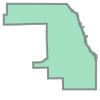

In [3]:
# Read polygon
cook_county_border = gpd.read_file("~/Desktop/GIS_drafts/Municipalities/Cook_County_Border.geojson")
cook_county_border

polygon = cook_county_border["geometry"].values.copy()[0]
translated_polygon = translate(polygon, xoff=360)
translated_polygon

In [4]:
# Select a GRIB2 file
files = Path("./data/20210626/").glob("*.grib2")
files = sorted(files)
file = files[350]

In [5]:
# Open file and do a coarse clip
ds = xr.open_dataset(file, engine="cfgrib", decode_timedelta=True)
extent = Extent((41.40, 42.2), (-88.30, -87.45))
xclip = ds.loc[extent.as_xr_slice()]

In [6]:
xclip

<xarray.Dataset> Size: 29kB
Dimensions:         (latitude: 80, longitude: 85)
Coordinates:
    time            datetime64[ns] 8B ...
    step            timedelta64[ns] 8B ...
    heightAboveSea  float64 8B ...
  * latitude        (latitude) float64 640B 42.2 42.19 42.18 ... 41.42 41.41
  * longitude       (longitude) float64 680B 271.7 271.7 271.7 ... 272.5 272.5
    valid_time      datetime64[ns] 8B ...
Data variables:
    unknown         (latitude, longitude) float32 27kB ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             161
    GRIB_centreDescription:  US NOAA Office of Oceanic and Atmospheric Research
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US NOAA Office of Oceanic and Atmospheric Research
    history:                 2025-03-11T17:16 GRIB to CDM+CF via cfgrib-0.9.1...

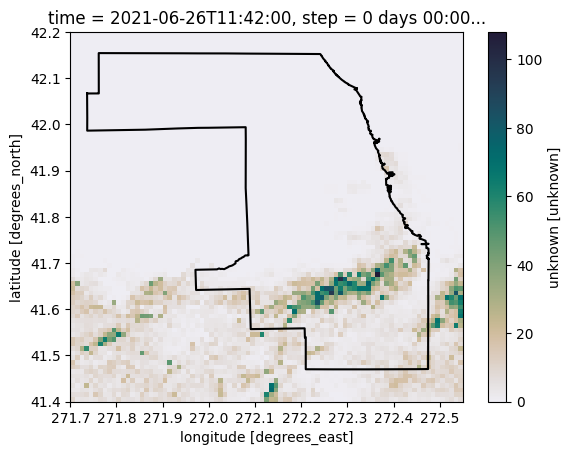

In [7]:
# Plot data with boundary
fig, ax = plt.subplots()
ax.set_aspect("equal")
xclip["unknown"].plot(cmap=cmocean.cm.rain, ax=ax)
ax.plot(*translated_polygon.exterior.xy, c="k")
plt.show()

In [8]:
# Generate points to evaluate
lon, lat = xclip.longitude, xclip.latitude
llon, llat = np.meshgrid(lon, lat)
points = np.vstack((llon.flatten(), llat.flatten())).T
points

array([[271.70499881,  42.195     ],
       [271.71499881,  42.195     ],
       [271.72499881,  42.195     ],
       ...,
       [272.52499878,  41.405     ],
       [272.53499878,  41.405     ],
       [272.54499878,  41.405     ]], shape=(6800, 2))

In [9]:
# Mask using the polygon.contains calculation
mask = [translated_polygon.contains(Point(x, y)) for x, y in points]
mask = np.array(mask).reshape(len(lat), len(lon))
mask_ds = xclip.where(mask)

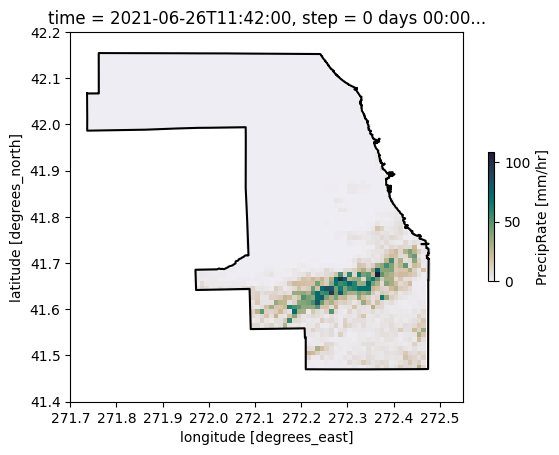

In [10]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
mask_ds["unknown"].plot(
    cmap=cmocean.cm.rain, ax=ax, cbar_kwargs=dict(label="PrecipRate [mm/hr]", shrink=0.35)
)
ax.plot(*translated_polygon.exterior.xy, c="k")
plt.show()

In [11]:
mask_ds["unknown"].sum()

<xarray.DataArray 'unknown' ()> Size: 4B
array(11096.299, dtype=float32)
Coordinates:
    time            datetime64[ns] 8B ...
    step            timedelta64[ns] 8B ...
    heightAboveSea  float64 8B ...
    valid_time      datetime64[ns] 8B ...